In [12]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization, Conv2D, AveragePooling2D, MaxPooling2D, ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2
from keras import backend as K

class ResNet:
    @staticmethod
    def residual_module(data, K, stride, chanDim, red=False, 
        reg=0.0001, bnEps=2e-5, bnMom=0.9):
            # the shortcut branch of the ResNet module should be
            # initialize as the input (identity) data
            shortcut = data
  
            # the first block of the ResNet module are the 1x1 CONVs
            bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(data)
            act1 = Activation("relu")(bn1)
            conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False, 
                           kernel_regularizer=l2(reg))(act1)
            # the second block of the ResNet module are the 3x3 CONVs
            bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(conv1)
            act2 = Activation("relu")(bn2)
            conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride, padding="same", use_bias=False, kernel_regularizer=l2(reg)(act2))
            # the third block of the ResNet module is another set of 1x1 CONVs
            bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,momentum=bnMom)(conv2)
            act3 = Activation("relu")(bn3)
            conv3 = Conv2D(K, (1, 1), use_bias=False, kernel_regularizer=l2(reg))(act3)
            # if we are to reduce the spatial size, apply a CONV layer to the shortcut
            if red:
               shortcut = Conv2D(K, (1, 1), strides=stride, use_bias=False, 
                    kernel_regularizer=l2(reg))(act1)

            # add together the shortcut and the final CONV
            x = add([conv3, shortcut])

            # return the addition as the output of the ResNet module
            return x
    
    
    @staticmethod
    def build(width, height, depth, classes, stages, filters, 
        reg=0.0001, bnEps=2e-5, bnMom=0.9):
        # initialize the input shape to be "channels last" and the
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            # set the input and apply BN
            inputs = Input(shape=inputShape)
            x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                momentum=bnMom)(inputs)
    
            # apply CONV => BN => ACT => POOL to reduce spatial size
            x = Conv2D(filters[0], (5, 5), use_bias=False,
                padding="same", kernel_regularizer=l2(reg))(x)
            x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                momentum=bnMom)(x)
            x = Activation("relu")(x)
            x = ZeroPadding2D((1, 1))(x)
            x = MaxPooling2D((3, 3), strides=(2, 2))(x)
        # loop over the number of stages
        for i in range(0, len(stages)):
            # initialize the stride, then apply a residual module
            # used to reduce the spatial size of the input volume
            stride = (1, 1) if i == 0 else (2, 2)
            x = ResNet.residual_module(x, filters[i + 1], stride,
                    chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

            # loop over the number of layers in the stage
            for j in range(0, stages[i] - 1):
                # apply a ResNet module
                x = ResNet.residual_module(x, filters[i + 1],
                    (1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)
        # apply BN => ACT => POOL
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
                momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = AveragePooling2D((8, 8))(x)
        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes, kernel_regularizer=l2(reg))(x)
        x = Activation("softmax")(x)
        
        # create the model
        model = Model(inputs, x, name="resnet")
        
        # return the constructed network architecture
        return model

In [14]:
model = ResNet()

In [16]:
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


%matplotlib inline

# Getting Data

In [17]:
with open('data/data_train', 'rb') as f:
  train_data = pickle.load(f)

In [18]:
with open('data/data_test', 'rb') as f:
  test_data = pickle.load(f)

In [19]:
with open('data/meta', 'rb') as f:
  classes = pickle.load(f)

In [20]:
train_data

{'section': 'train',
 'labels': array([1, 3, 2, ..., 7, 5, 8], dtype=uint8),
 'images': array([[[[ 21.,  27.,  49.],
          [ 18.,  20.,  44.],
          [ 13.,  13.,  41.],
          ...,
          [  0.,   4.,   6.],
          [  0.,   4.,   4.],
          [  0.,   4.,   3.]],
 
         [[ 28.,  36.,  56.],
          [ 26.,  32.,  56.],
          [ 21.,  25.,  52.],
          ...,
          [  1.,   5.,   8.],
          [  0.,   4.,   4.],
          [  0.,   3.,   2.]],
 
         [[ 55.,  64.,  80.],
          [ 54.,  61.,  81.],
          [ 48.,  54.,  77.],
          ...,
          [  1.,   5.,   8.],
          [  0.,   4.,   5.],
          [  1.,   5.,   4.]],
 
         ...,
 
         [[ 55.,  47.,  57.],
          [ 36.,  31.,  40.],
          [ 19.,  16.,  24.],
          ...,
          [  7.,   8.,   8.],
          [  7.,   9.,   8.],
          [  7.,   8.,   8.]],
 
         [[ 18.,   8.,  22.],
          [ 14.,   7.,  20.],
          [  8.,   4.,  14.],
          ...,


In [21]:
test_data

{'section': 'test',
 'images': array([[[[ 67.,  73.,  87.],
          [ 74.,  78.,  92.],
          [ 76.,  78.,  94.],
          ...,
          [ 57.,  64.,  81.],
          [ 54.,  61.,  77.],
          [ 49.,  56.,  72.]],
 
         [[ 68.,  74.,  88.],
          [ 72.,  76.,  92.],
          [ 73.,  75.,  93.],
          ...,
          [ 66.,  75.,  89.],
          [ 65.,  72.,  88.],
          [ 61.,  69.,  84.]],
 
         [[ 68.,  74.,  88.],
          [ 70.,  74.,  90.],
          [255., 255., 255.],
          ...,
          [ 85.,  91., 101.],
          [ 86.,  91., 101.],
          [ 84.,  89.,  99.]],
 
         ...,
 
         [[ 60.,  73.,  86.],
          [ 57.,  69.,  84.],
          [255., 255., 255.],
          ...,
          [ 81.,  87.,  97.],
          [ 82.,  90.,  98.],
          [ 83.,  90.,  96.]],
 
         [[ 58.,  70.,  84.],
          [ 52.,  64.,  79.],
          [ 48.,  59.,  76.],
          ...,
          [ 71.,  76.,  90.],
          [ 72.,  79.,  89.

In [22]:
classes

{'label_names': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}

In [23]:
train_images_full = train_data['images']
train_labels_full = train_data['labels']

In [24]:
train_images_full.shape

(50000, 32, 32, 3)

In [25]:
train_images_full = train_images_full / 255.0

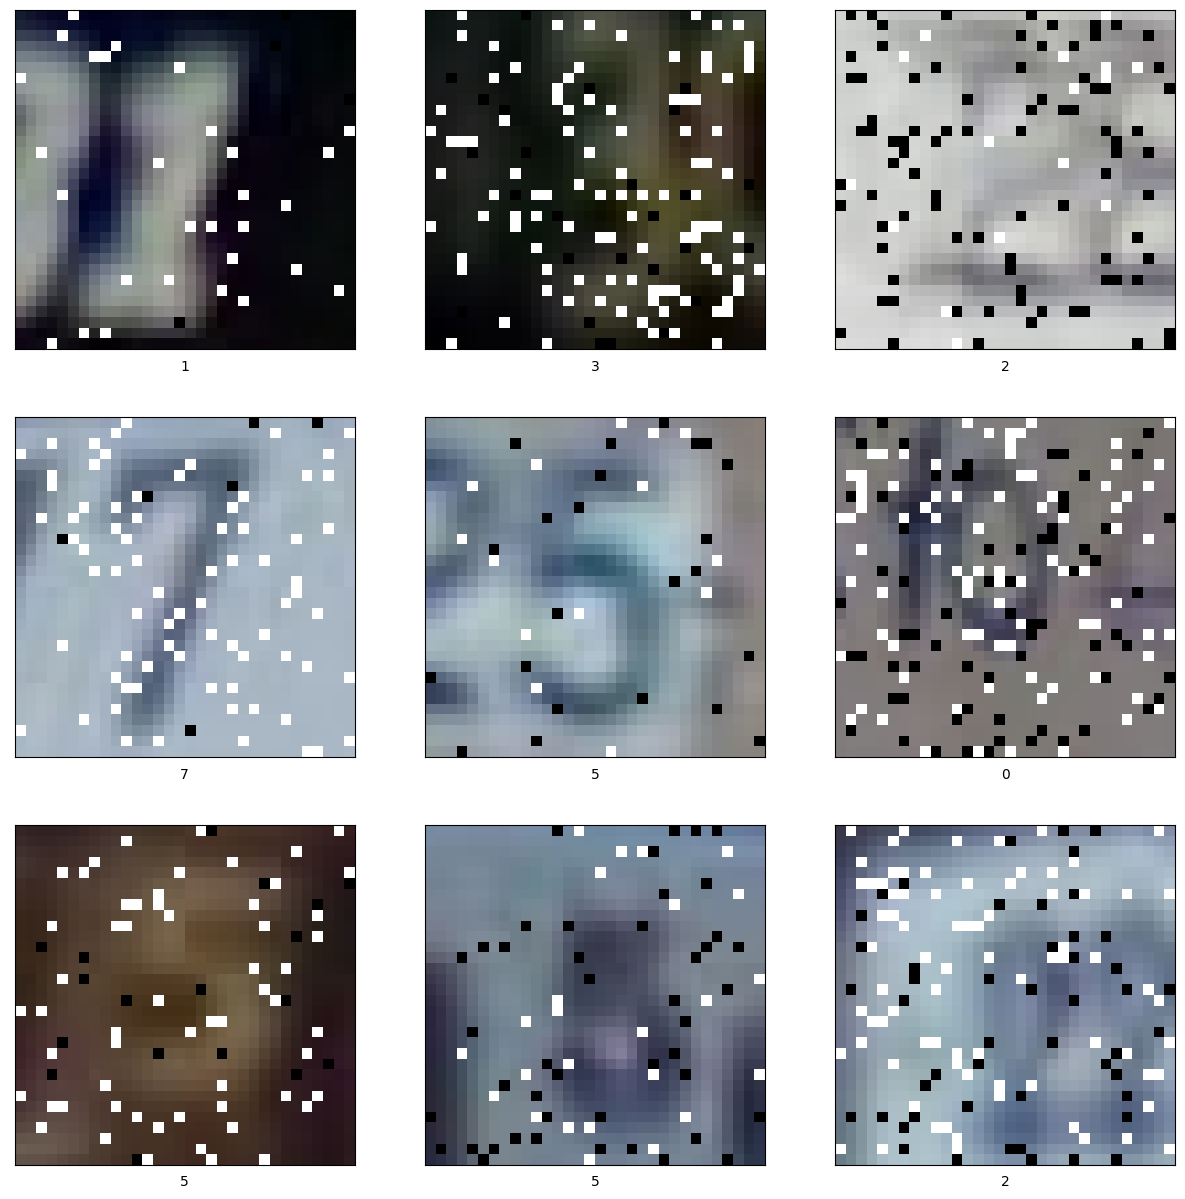

In [26]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_full[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels_full[i])
plt.show()

In [27]:
train_images, validation_images, train_labels, validation_labels = train_test_split(train_images_full, train_labels_full, test_size=0.01, random_state=0)

In [28]:
train_images.shape

(49500, 32, 32, 3)

In [29]:
validation_images.shape

(500, 32, 32, 3)

In [30]:
batch_size = 512

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

val_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

In [31]:
train_dataset = train_dataset.shuffle(buffer_size = 1024, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)

val_dataset = val_dataset.batch(batch_size)

In [33]:
model.residual_module(train_images, 10, 2, 0, red=True)

ValueError: Could not interpret regularizer identifier: 1639.586669921875